# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
!conda env list

# conda environments:
#
GoogEarthEngine          /home/jp/miniconda2/envs/GoogEarthEngine
astroconda               /home/jp/miniconda2/envs/astroconda
everest-pipeline         /home/jp/miniconda2/envs/everest-pipeline
helios                   /home/jp/miniconda2/envs/helios
iraf27                   /home/jp/miniconda2/envs/iraf27
ircs_pol                 /home/jp/miniconda2/envs/ircs_pol
moscatel              *  /home/jp/miniconda2/envs/moscatel
radmc3dpy                /home/jp/miniconda2/envs/radmc3dpy
sprout                   /home/jp/miniconda2/envs/sprout
vip                      /home/jp/miniconda2/envs/vip
root                     /home/jp/miniconda2



In [3]:
import os
from glob import glob
import getpass

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

In [4]:
from tqdm import tqdm
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf

#suppose these come form config file
filters_in_config = 'g,r,z_s'.split(',')
bands = {}

for j in filters_in_config:
    #initialize dict with empty arrays
    j=j.strip(' ')
    bands[j]=[]
filters_in_hdr=[]
        
for i in tqdm(file_list):
    hdr = pf.getheader(i)
    filters_in_hdr.append(hdr['FILTER'])
    for j in filters_in_config:
        if hdr['FILTER'] == j:
            j=j.strip(' ')
            bands[j].append(i)

for key in bands.keys():
    print('{0}-band: {1} frames'.format(key, len(bands[key])))

100%|██████████| 1456/1456 [00:06<00:00, 242.23it/s]

z_s-band: 376 frames
r-band: 704 frames
g-band: 376 frames


In [6]:
pf.getheader(file_list[0])[:10]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32                                                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT *********************                                                   
COMMENT       Time                                                              

## Stack (some) raw images

In [9]:
import numpy as np

def stack_raw_image(image_list, skip_every=1):
    '''
    stack image using median to be used for detecting 
    source locations (i.e. target and ref stars)
    '''
    image_array = []
    for i in tqdm(image_list[::skip_every]):
        img = pf.getdata(i)
        image_array.append(img)
    stacked_image = np.median(image_array, axis=0)
    return stacked_image

In [10]:
stacked_images = []
for key in bands.keys():
    stacked_images.append(stack_raw_image(bands[key], skip_every=10))

100%|██████████| 38/38 [00:00<00:00, 53.70it/s]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.visualization import ZScaleInterval

def show_stacked_images(images):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    titles='g,r,z'.split(',')
    for i,img in enumerate(images):
        vmin,vmax= ZScaleInterval().get_limits(img)
        axes[i].imshow(img,vmin=vmin,vmax=vmax)
        axes[i].set_title(titles[i])
    #return None

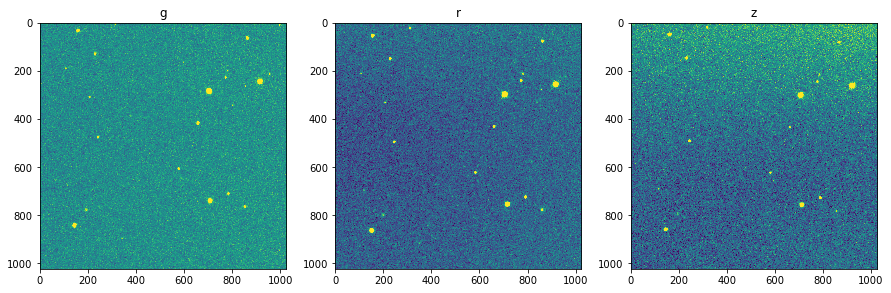

In [12]:
show_stacked_images(stacked_images)

## Detect point sources

In [13]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def get_sources(img, num_stars=10, fwhm=8.0):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)  
    sources = daofind(img - median)
    #convert to pandas dataframe for easy sorting
    sources = sources.to_pandas()
    #sort by brightness
    sources = sources.sort_values(by='peak',ascending=False)
    
    return sources.head(num_stars)

In [14]:
sources = []

for idx, img in enumerate(stacked_images):
    sources.append(get_sources(img, num_stars=20))

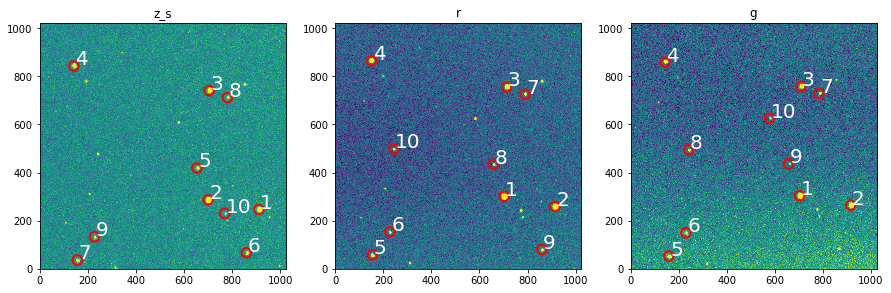

In [15]:
from photutils import CircularAperture
from astropy.visualization import ZScaleInterval
from photutils.detection import find_peaks
from astropy.stats import sigma_clipped_stats

def show_sources(image, sources, labels, method='sources', num_stars=10):
    '''
    similar to `show_peaks`; difference is `sources` used as input
    '''
    if isinstance(image, np.ndarray):
        if method == 'peaks':
            positions = (peaks['x_peak'].values[:num_stars], peaks['y_peak'].values[:num_stars])
        else: #default
            positions = (sources['xcentroid'].values[:num_stars], sources['ycentroid'].values[:num_stars])
        
        apertures = CircularAperture(positions, r=20.)
        vmin,vmax= ZScaleInterval().get_limits(image)
        plt.figure(figsize=(10,10))
        plt.imshow(image, origin='lower', vmin=vmin,vmax=vmax)
        for num, (x,y) in enumerate(zip(positions[0],positions[1])):
            plt.text(x+5,y+5, num+1, fontsize=20, color='w')
        apertures.plot(color='r', lw=2)
            
    elif len(image) == len(sources) and isinstance(image, list):
        fig, ax = plt.subplots(1,len(image),figsize=(15,5))
        for idx,(img,src) in enumerate(zip(image,sources)):
            positions = (src['xcentroid'].values[:num_stars], src['ycentroid'].values[:num_stars])
            apertures = CircularAperture(positions, r=20.)
            vmin,vmax= ZScaleInterval().get_limits(img)
            ax[idx].imshow(img, origin='lower', vmin=vmin,vmax=vmax)
            for num, (x,y) in enumerate(zip(positions[0],positions[1])):
                ax[idx].text(x+5,y+5, num+1, fontsize=20, color='w')
            apertures.plot(color='r', lw=2, ax=ax[idx])
        for idx, label in enumerate(labels):
            ax[idx].set_title(label)
            
    else:
        print('incorrect dimensions')
    
    #return None
    
show_sources(stacked_images, sources, list(bands.keys()), num_stars=10)

comparison star is probably GSC [03465-00123](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%408352953&Name=GSC%2003465-00123&submit=submit)

note that star 1 and 2 is different in g-band.

sample image

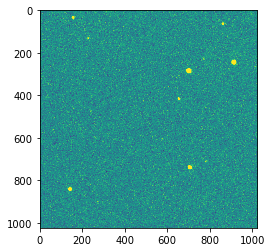

In [16]:
from astropy.visualization import ZScaleInterval

sample_img = pf.open(bands['z_s'][0])[0].data
vmin,vmax= ZScaleInterval().get_limits(sample_img)
plt.imshow(sample_img,vmin=vmin,vmax=vmax)

## Crop image

In [17]:
import numpy as np

def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

## Compute Centroid 

In [18]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

def get_centroid(image, method='com'):
    '''
    centroid_com(): Calculates the object “center of mass” from 2D image moments.
    centroid_1dg(): Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
    centroid_2dg(): Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.
    Default is centroid_2dg.
    ''' 
    if method=='com':
        x, y = centroid_com(image)
    
    elif method=='1d_gaussian':
        x, y = centroid_1dg(image)

    else: #default
        x, y = centroid_2dg(image)
        
    return (x,y)

## Estimate background

In [19]:
from photutils import CircularAnnulus

def get_bkg(image, centroid, r_in=10., r_out=20.):
    annulus = CircularAnnulus(centroid, r_in, r_out)
    result = aperture_photometry(image_crop, annulus)
    bkg_mean = result['aperture_sum'] / annulus.area()
    return bkg_mean

In [20]:
from photutils import CircularAperture
from photutils import aperture_photometry

def get_phot2(image, bkg_mean, centroid, r=10):
        
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image - bkg_mean, apertures)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

## aperture photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)

for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)

In [21]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r=10):
    '''
    r is based from measured fwhm = 8.0
    '''
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

In [22]:
idx=2; #0:g, 1:r, 2:z_s

centroid_xy = list(zip(sources[idx]['xcentroid'],sources[idx]['ycentroid']))
centroid_xy

[(702.82130824352134, 303.33911260721948),
 (914.91854174262744, 263.88871354492659),
 (707.37585836472431, 757.73533211472306),
 (143.77824030763367, 859.17891260292129),
 (158.96149009998032, 52.121706539897481),
 (230.06883510909384, 148.94240691484046),
 (783.76636270868153, 729.02153278997332),
 (241.9658930784698, 493.59509181977211),
 (656.99703918448552, 436.13474322146874),
 (577.58284403497578, 625.13756465060521),
 (862.9309701194569, 84.545295911958618),
 (772.49665399566629, 247.35853345770479),
 (314.6812629387241, 21.859660804662077),
 (852.72686348335719, 782.8172399425855),
 (780.79668610375734, 218.38502135028995),
 (837.05151349840435, 334.73711967778502),
 (115.20990637419919, 691.13531231621118)]

In [23]:
#centroid_xy = (703, 303)
box_size = 80
#crop
image_crop = get_crop(sample_img, centroid_xy[0], box_size)
#compute centroid
centroid = get_centroid(image_crop)

flux = []
apertures = np.arange(2,80,3)

for i in apertures:
    flux.append(get_phot(image_crop, centroid, r=i))

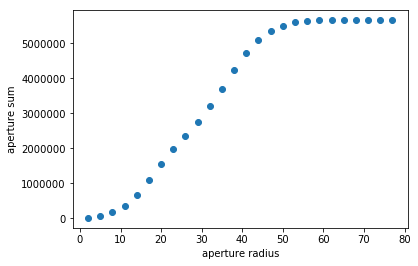

In [24]:
plt.plot(apertures,flux,'o')
plt.xlabel('aperture radius')
plt.ylabel('aperture sum')

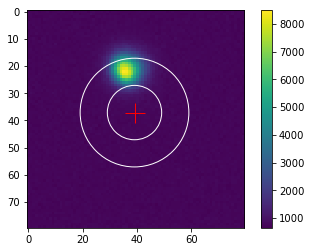

In [25]:
plt.imshow(image_crop)
plt.colorbar()
plt.plot(centroid[0],centroid[1],'+', c='r', ms=20, lw=10)
CircularAperture(centroid, r=10).plot(color='w')
CircularAperture(centroid, r=20).plot(color='w')

In [26]:
from photutils import CircularAnnulus

annulus = CircularAnnulus(centroid, r_in=10., r_out=20.)
result = aperture_photometry(image_crop, annulus)

In [27]:
bkg_mean = result['aperture_sum'] / annulus.area()

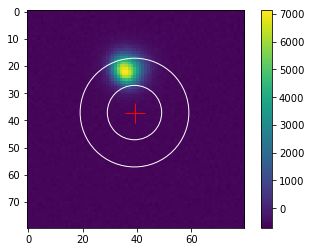

In [28]:
plt.imshow(image_crop-bkg_mean)
plt.colorbar()
plt.plot(centroid[0],centroid[1],'+', c='r', ms=20, lw=10)
CircularAperture(centroid, r=10).plot(color='w')
CircularAperture(centroid, r=20).plot(color='w')

In [29]:
image_crop.shape

(80, 80)

## fwhm

In [30]:
def get_fwhm(image_crop):
    # https://python4astronomers.github.io/fitting/sherpa.html
    i,j = np.unravel_index(image_crop.argmax(), image_crop.shape) #take x,y max
    peak_x=image_crop[i,:]
    peak_y=image_crop[:,j]
    try:
        sigma=model_gaussian(peak_x, peak_y)
        fwhm=2.355*np.abs(sigma)
    except:
        #no good estimate
        fwhm=np.nan
        
    return fwhm

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

def model_gaussian(peak_x, peak_y,verbose=False):
    #estimate mean and standard deviation
    ydata = (peak_x+peak_y)/2.0
    xdata = np.array(range(len(ydata)))
    xmean = len(xdata)/2
    sigma = np.std(ydata)
    amp = np.max(ydata)
    eps =0.1
    #fitting
    popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [amp, xmean, sigma, eps])

    #plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
    #plt.plot(xdata,ydata,'ok', label='data')
    #plt.legend()
    if verbose==True:
        print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(popt[0],popt[1], popt[2], popt[3]))
    return popt[2]

In [31]:
from astropy.stats import sigma_clipped_stats
from astropy.modeling import fitting
from astropy.modeling.models import Gaussian2D

def get_fwhm_2D(img, method='LevMarLSQFitter', verbose=False):
    #normalize
    img /=np.max(img)    
    amplitude, x_mean, y_mean =1,img.shape[0]/2,img.shape[1]/2
    #initialize
    g_init = Gaussian2D(amplitude, x_mean, y_mean)
    if method == 'LevMarLSQFitter':
        fit_g = fitting.LevMarLSQFitter()
    elif method == 'SimplexLSQFitter':
        fit_g = fitting.SimplexLSQFitter()
    else:
        print('incorrect method')
        
    xshape,yshape=img.shape[0],img.shape[1]
    xgrid, ygrid = np.mgrid[-xshape/2:xshape/2, -yshape/2:yshape/2]
    #begin fit
    g = fit_g(g_init, range(xshape), range(yshape), img[range(yshape),range(xshape)])
    
    if verbose:
        print('{0}\n{1}'.format(g.param_sets, g.param_names))
        #residual
#         plt.imshow(g(y,x)-img)
#         plt.colorbar()
    return 2.355*np.abs(np.mean(g.param_sets[3:4]))

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [32]:
from datetime import datetime as dt

def make_lightcurve(band_idx):
    for star_idx in range(3):
        xcenters, ycenters = [],[]
        aperture_sums = []
        obs_time = []
        obs_mjd = []
        fwhm = []
        sum_per_band = {}

        ##extract lightcurve (enumerate all frames) in a given band
        for i in tqdm(bands[band_idx]):
            hdr = pf.open(i)[0].header
            img = pf.open(i)[0].data

            #get dates from fits header
            date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
            time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
            newdate = time.replace(year=date.year, month=date.month, day=date.day)
            obs_time.append(newdate)
            obs_mjd.append(hdr['MJD-STRT'])
            
            #crop
            image_crop = get_crop(img, centroids[star_idx], box_size)
            #compute centroid
            centroid = get_centroid(image_crop)
            centroids.append(centroid)

            xcenters.append(centroid[0])
            ycenters.append(centroid[1])
            
            #do photometry
            aperture_sum = get_phot(image_crop, centroid, r=20)
            aperture_sums.append(aperture_sum)
            
            #fwhm
            fwhm.append(get_fwhm(image_crop))

        #output as dataframe of given band and star
        dfs.append(pd.DataFrame(
            {'{0}_{1}_x'.format(band_name[band_idx], star_names[star_idx]) : xcenters,
             '{0}_{1}_y'.format(band_name[band_idx], star_names[star_idx]) : ycenters,
             '{0}_{1}_flux'.format(band_name[band_idx], star_names[star_idx]) : aperture_sums,
             '{0}_{1}_fwhm'.format(band_name[band_idx], star_names[star_idx]) : fwhm},
            index = obs_time))
        
    return dfs, band_idx

In [33]:
def plot_lightcurve(dfs, band_idx, showfig=None):
    df = pd.concat(dfs, axis=1)
    #df.head()

    if band_idx==0:
        cols = 'g_a_flux g_b_flux g_c_flux'.split()

    elif band_idx==1:
        cols = 'r_a_flux r_b_flux r_c_flux'.split()

    else:
        cols = 'z_a_flux z_b_flux z_c_flux'.split()
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    if showfig==None or showfig==True:
        df[cols].plot(subplots=True, figsize=(15,8),ax=ax)
        
    return df

In [34]:
def df_phot(target, ref, df, showfig=None):
    if target=='a':
        t=df.columns[0]
    elif target=='b':
        t=df.columns[3]
    else:
        t=df.columns[6]
    if ref=='a':
        r=df.columns[0]
    elif target=='b':
        r=df.columns[3]
    else:
        r=df.columns[6]
        
    res=df[t]/df[r]
    
    fig, ax2 = plt.subplots(1,1,figsize=(10,8))
    if showfig==None or showfig==True:
        res.plot(figsize=(15,5), color='k', marker='o', linestyle='none', ax=ax2);
        
    return res

In [35]:
gband = bands['g']
rband = bands['r']
zband = bands['z_s']

100%|██████████| 376/376 [00:05<00:00, 71.59it/s]
/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/pandas/plotting/_core.py:1682: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


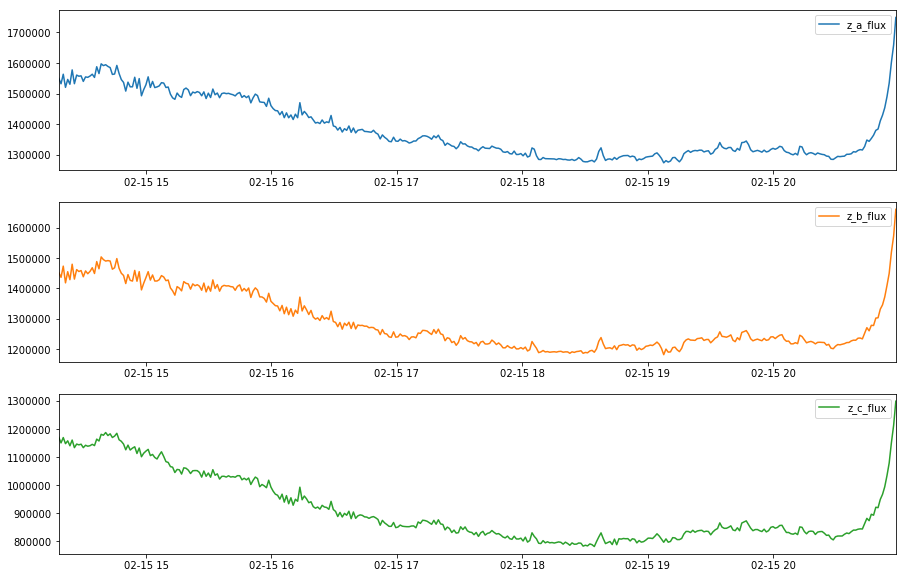

In [36]:
import pandas as pd
#import multiprocessing

box_size = 80

bands = [gband,rband,zband]
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
star_names = 'abc'

dfs = []

##loop in 3 stars given band  
dfs, band_idx =  make_lightcurve(band_idx=2)

#plot fluxes
df = plot_lightcurve(dfs, band_idx)

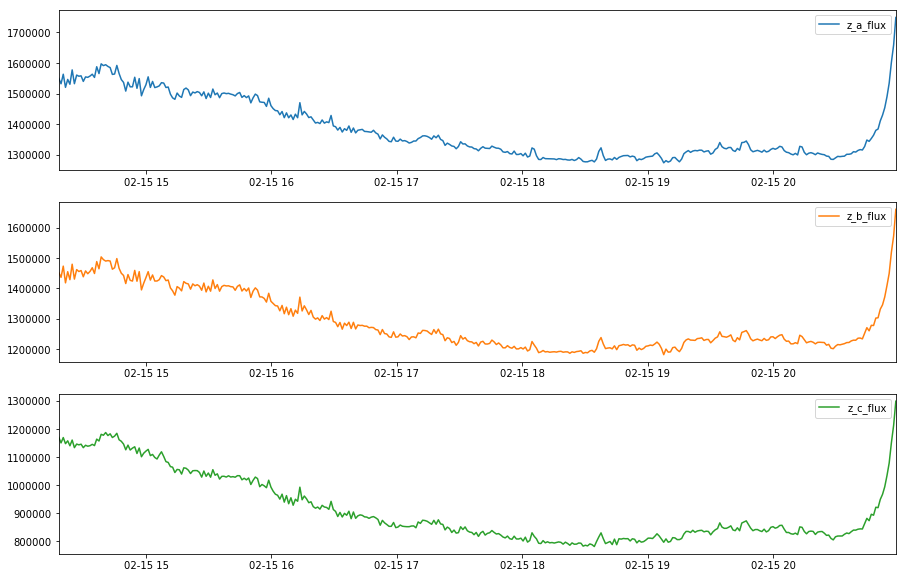

In [37]:
#plot fluxes
df = plot_lightcurve(dfs, key)

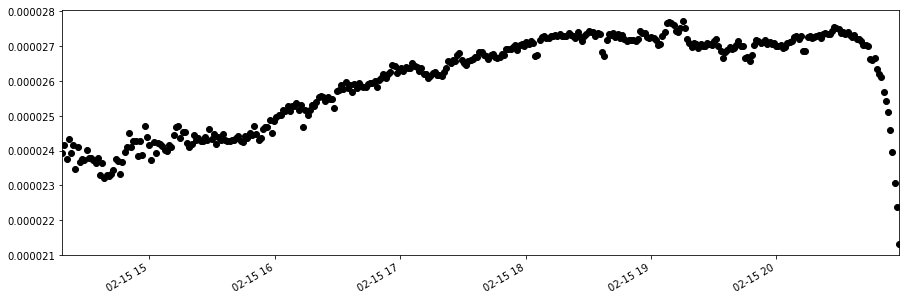

In [38]:
#differential photometry
res = df_phot('b', 'a', df, showfig=True)

## Analysis: 

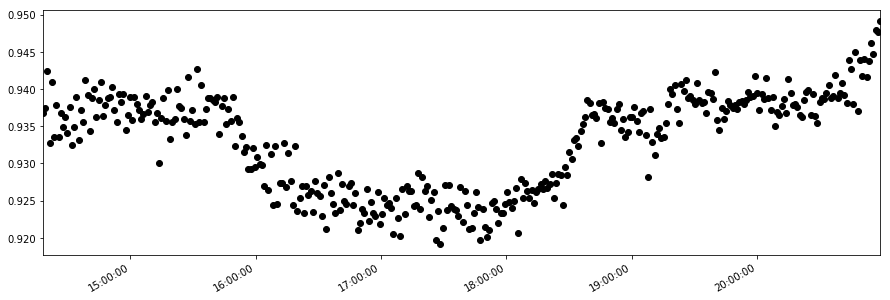

In [46]:
from matplotlib import dates
date_fmt = '%H:%M:%S' #%d/%m/%y 

formatter = dates.DateFormatter(date_fmt)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.xaxis.set_major_formatter(formatter)
(df['z_b_flux'] / df['z_a_flux']).plot(ax=ax, color='k', marker='o', linestyle='none')
plt.gcf().autofmt_xdate()